In [1]:
# standard libraries
import numpy as np
import math
from pprint import pprint as pp
from matplotlib.pyplot import *
%matplotlib inline

In [2]:
# user library
from bayesee.detector.spotter import UncertainSpotter
from bayesee.imaging.filter import *
from bayesee.imaging.image import *
from bayesee.operation.nb2d import *
from bayesee.operation.dp import *
from bayesee.operation.mathfunc import *

In [3]:
# stimulus parameters
row = col = 128
i_row = i_col = 256
ppd = 120
cpd = 1.5
cpi_v = row * cpd / ppd
field_ratio = 8

In [4]:
# simulation parameters
n_background = 1000
background_mean = 128
background_std = 128 * 0.204
n_iter = 3
dp_tar = 1

In [5]:
# templates
rc_template = hann_window(row, col, row/2)
rc_template /= nb2dot(rc_template, rc_template)

sine_template = hann_window(row, col, row/2) * sine_wave(row, col, (cpi_v,0))
sine_template /= nb2dot(sine_template, sine_template)

tri_template = hann_window(row, col, row/2) * sine_triangle_wave(row, col, (cpi_v, 0))
tri_template /= nb2dot(tri_template, tri_template)

sqr_template = hann_window(row, col, row/2) * sine_square_wave(row, col, (cpi_v, 0))
sqr_template /= nb2dot(sqr_template, sqr_template)

In [6]:
# backgrounds
uni_images = np.zeros((i_row, i_col, n_background))
cm_images = np.zeros((i_row, i_col, n_background))

for i in range(n_background):
    uni_images[:,:,i] = power_noise(i_row, i_col, -1, background_mean, background_std)
    cm_images[:,:,i] = contrast_modulate_lr(power_noise(i_row, i_col, -1, background_mean, background_std), 4)

In [7]:
# spotters
uni_weighting_matrix = np.ones((i_row,i_col))
cm_weighting_matrix = luminance_modulate_lr(uni_weighting_matrix, 4, flip=True)
uncer_std = 0.083*ppd/16
uncer={'size': uncer_std, 'func': lambda x: np.exp(-(x/uncer_std)**2/2) * np.sqrt(2*np.pi), 'info': 'prior', 'focus': 'max'}

UTM = UncertainSpotter(method='UTM', uncer=uncer)
UWTM = UncertainSpotter(method='UWTM', whiten=1, uncer=uncer)
uni_URTM = UncertainSpotter(method='URTM', weight=uni_weighting_matrix, uncer=uncer)
cm_URTM = UncertainSpotter(method='URTM', weight=cm_weighting_matrix, uncer=uncer)
uni_UWRTM = UncertainSpotter(method='UWRTM', whiten=1, weight=uni_weighting_matrix, uncer=uncer)
cm_UWRTM = UncertainSpotter(method='UWRTM', whiten=1, weight=cm_weighting_matrix, uncer=uncer)

In [8]:
# simulation function
def detection_1_f_noise(model, template, background, amp_init, n_iter):
    n_total = n_iter * n_background * 2
    amp = np.ones((n_total,)) * amp_init
    stimulus = np.ones((n_total,))
    response = np.ones((n_total,))
    amp_iter = np.ones((n_background * 2,)) * amp_init
    stimulus_iter = np.ones((n_background * 2,))
    response_iter = np.ones((n_background * 2,))

    for i in range(n_iter):
        for j in range(n_background):
            stimulus_iter[2*j] = 0
            response_iter[2*j] = model.give_response(background[:,:,j], template)
            stimulus_iter[2*j+1] = 1
            response_iter[2*j+1] = model.give_response(add_to_center(background[:,:,j], amp_iter[0]*template), template)
            
        amp[i*n_background*2:(i+1)*n_background*2] = amp_iter
        stimulus[i*n_background*2:(i+1)*n_background*2] = stimulus_iter
        response[i*n_background*2:(i+1)*n_background*2] = response_iter
            
        if np.isnan(amp_iter).any() or np.isinf(amp_iter).any():
            amp_iter[:] = (np.random.rand() + 0.5) * amp_init / (2**i)
        else:
            dp,_,_ = glm_cont_linear(amp_iter, stimulus_iter, response_iter)
            amp_iter[:] *= dp_tar / dp[0] * (np.random.rand() + 0.5)
    
    return amp, stimulus, response

(array([  18.,   91.,  308.,  788., 1418., 1368., 1236.,  605.,  149.,
          19.]),
 array([5.12871622, 5.1818072 , 5.23489817, 5.28798915, 5.34108012,
        5.3941711 , 5.44726207, 5.50035305, 5.55344402, 5.606535  ,
        5.65962597]),
 <BarContainer object of 10 artists>)

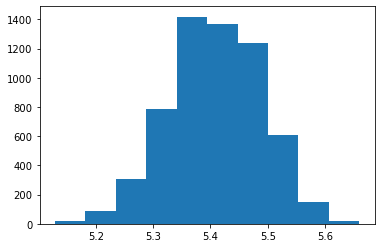

In [12]:
hist(temp_data[2])

In [14]:
# simulation
templates = [rc_template, sine_template, tri_template, sqr_template]
backgrounds = [uni_images, cm_images]
models = [UTM, UWTM, uni_URTM, uni_UWRTM]
amp_init = 1

thresholds = np.zeros((len(templates), len(backgrounds), len(models)))
for t, template in enumerate(templates):
    for b, background in enumerate(backgrounds):
        temp_data = detection_1_f_noise(UTM, template, background, amp_init, n_iter)
        thresholds[t,b,0] = uncertain_cont_th(*temp_data)
        thresholds[t,b,1] = uncertain_cont_th(*detection_1_f_noise(UWTM, template, background, amp_init, n_iter))
        thresholds[t,b,2] = uncertain_cont_th(*detection_1_f_noise(uni_URTM, template, background, amp_init, n_iter)) if b==0 else uncertain_cont_th(*detection_1_f_noise(cm_URTM, template, background, amp_init, n_iter))
        thresholds[t,b,3] = uncertain_cont_th(*detection_1_f_noise(uni_UWRTM, template, background, amp_init, n_iter)) if b==0 else uncertain_cont_th(*detection_1_f_noise(cm_UWRTM, template, background, amp_init, n_iter))
        
db_thresholds = decibel(thresholds)        
pp(thresholds)

ValueError: Residuals are not finite in the initial point.

In [ ]:
# plot function

def plot_db_thresholds(db_thresholds, pargs):
    n_templates, n_backgrounds, n_models = db_thresholds.shape
    n_rows, n_cols = pargs['n_rows'], pargs['n_cols']
    fig, axs = subplots(nrows=n_rows, ncols=n_cols, figsize=pargs['figsize'], constrained_layout=True)
    db_th_min = db_thresholds.min() - 0.1 * db_thresholds.ptp()
    db_th_max = db_thresholds.max() + 0.1 * db_thresholds.ptp()
    
    for i in range(n_models):
        idxes = i//n_rows, i%n_rows
        axs[idxes].scatter(pargs['x_tick_labels'], db_thresholds[:,0,i], s=pargs['markersize'], marker=pargs['markers'][i], edgecolor=pargs['colors'][i], facecolor="none", linewidths=pargs['linewidth'], label=pargs['legends'][i])
        axs[idxes].scatter(pargs['x_tick_labels'], db_thresholds[:,1,i], s=pargs['markersize'], marker=pargs['markers'][i], edgecolor=pargs['colors'][i], facecolor=pargs['colors'][i], linewidths=pargs['linewidth'])
        axs[idxes].set_xlim(-0.5, n_templates-0.5)
        axs[idxes].set_ylim(db_th_min, db_th_max)
        axs[idxes].legend(loc='best', fontsize=pargs['fontsizes'][1])
        
        axs[idxes].tick_params(axis='x', which='both', direction='out', length=0, width=0,pad=5, labelsize=pargs['fontsizes'][2], labelbottom=True, labeltop=False, grid_color='k', grid_alpha=1, grid_linewidth=1, grid_linestyle='--')
        axs[idxes].grid(visible=True, which='minor', axis='x', linestyle='--', linewidth=pargs['linewidth'])
        axs[idxes].tick_params(axis='y', which='major', direction='out', length=12, width=4, pad=3, labelsize=pargs['fontsizes'][2], left=True, right=True, labelleft=True, labelright=True)
        axs[idxes].tick_params(axis='y', which='minor', direction='out', length=8, width=4, left=True, right=True, labelleft=False, labelright=False)

    fig.text(0.5, -0.05, pargs['x_label'], ha='center', fontsize=pargs['fontsizes'][0])
    fig.text(-0.05, 0.5, pargs['y_label'], va='center', rotation='vertical', fontsize=pargs['fontsizes'][0])
    savefig('plot_accuracy_' + pargs['plot_name'] + '.svg', dpi=300, bbox_inches='tight')
    close()

In [ ]:
# plot
n_mod = len(models)
n_row = 2
n_col = math.ceil(n_mod / 2)
pargs = {'plot_name': 'uncertain-detection-1-f-noise', 'figsize': (20, 8), 'n_rows': n_row, 'n_cols': n_col, 'fontsizes': [36, 18, 15], 'x_label': 'Target', 'y_label': 'Threshold (dB)', 'x_tick_labels': ['rc', 'sine', 'tri', 'sqr'], 'legends': ['TM', 'WTM', 'RTM', 'WRTM'], 'markers': ['D', 'D', 'D', 'D'], 'colors': ['steelblue', 'firebrick', 'forestgreen', 'indigo'], 'markersize': 500, 'linewidth': 3}
plot_db_thresholds(db_thresholds, pargs)